In [0]:
!pip install h2o
!pip install pandarallel --user
from pandarallel import pandarallel
pandarallel.initialize(progress_bar = True)

    100% |████████████████████████████████| 48.5MB 247kB/s 
    100% |████████████████████████████████| 51kB 7.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/dd/ce/56/a7e16ba4f1e9e295042ed67d625c118953182a278c5fa5f51b
Successfully built pandarallel
  The script plasma_store is installed in '/root/.local/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  The script tqdm is installed in '/root/.local/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


ModuleNotFoundError: ignored

In [0]:
#google drive os
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("drive/My Drive/Colab Notebooks/Data/FeatureEngineering")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileNotFoundError: ignored

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix
from termcolor import colored

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn import metrics
import xgboost as xgb


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [0]:
def df_to_h2oF(data, factor_list):
    
    data[factor_list] = data[factor_list].astype(int)
    h2o_df = H2OFrame(data)
    h2o_df[factor_list] = h2o_df[factor_list].asfactor()
    
    return h2o_df

In [0]:
def corn_process(filename):
    data_corn = pd.read_csv(filename, index_col= 0, parse_dates=[0])
    
    data_corn = data_corn[~data_corn.isin([np.nan, np.inf, -np.inf]).any(1)]
    
    #for renhao's purpose
    pd.DataFrame(data_corn.index).to_csv('corn_whole_index_cleaned.csv')
    
    factor_list_Cap = ['Feature_57', 'Feature_58', 'Feature_45','Feature_47']
    
    numeric_list = list(set(data_corn.columns) - set(factor_list_Cap))
    
    data_corn[numeric_list] = data_corn[numeric_list].apply(lambda x: (x-np.mean(x))/np.std(x), axis = 0)
    
    standardized_saved_model = h2o.load_model('./leader_standardize_0424/XGBoost_1_AutoML_20190424_070314')
    
    standardized_corn_predict = standardized_saved_model.predict(df_to_h2oF(data_corn,factor_list_Cap))
    
    standardized_corn_predict_df = h2o.as_list(standardized_corn_predict)
    
    standardized_corn_predict_df.to_csv('standardized_corn_predict.csv')
    
    return standardized_corn_predict_df
    

In [0]:
corn_process('Report_Features_Corn.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%


,predict,p0,p1
0,0,0.999829,0.000171
1,0,0.998819,0.001181
2,0,0.999828,0.000172
3,0,0.999785,0.000215
4,0,0.997385,0.002615
5,0,0.982586,0.017414
6,0,0.999438,0.000562
7,0,0.999082,0.000918
8,0,0.999805,0.000195
9,0,0.999827,0.000173


In [0]:
def es_process(filename, no_of_models, debug = False):
               
    data = pd.read_csv(filename, index_col= 0, parse_dates=[0])
    remove_data = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]
    factor_list_es = ['feature_57', 'feature_58', 'Feature_45','Feature_47', 'Target']
    numeric_list_es = list(set(remove_data.columns) - set(factor_list_es))
    remove_data[numeric_list_es] = remove_data[numeric_list_es].apply(lambda x: (x-np.mean(x))/np.std(x), axis = 0)
    #true label
    X = remove_data.iloc[:,:-1]
    y = remove_data['Target']
    import warnings
    warnings.filterwarnings("ignore")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, shuffle=False)
    #for Ren Hao's usage
    #pd.DataFrame(X_train.index).to_csv('cleaned_train_index.csv')
    #pd.DataFrame(X_test.index).to_csv('cleaned_test_index.csv')
    sm = SMOTE(ratio = 'minority')
    X_resampled, y_resampled = sm.fit_sample(X= np.nan_to_num(X_train), y = np.nan_to_num(y_train))
    #X_resampled, y_resampled = X_train, y_train
    from h2o.automl import H2OAutoML
    import h2o
    from h2o.frame import H2OFrame
    h2o.init()
    df = remove_data.copy(deep = True)
    h2o_df = df_to_h2oF(df, factor_list_es)
    
    train_tmp, test_tmp = train_test_split(remove_data, test_size = 1/3, shuffle = False)
    train_h2o =  df_to_h2oF(train_tmp, factor_list_es)
    test_h2o = df_to_h2oF(test_tmp, factor_list_es)
   
    test_h2o_to_aml = test_h2o #save for test 
    train_h2o_resample_df = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis = 1 )
    train_h2o_resample_df.columns = df.columns
    train_h2o_resample_h2oframe = df_to_h2oF(train_h2o_resample_df, factor_list_es)
    #training
    x = train_h2o_resample_h2oframe.columns
    y = 'Target'
    x.remove(y)
    if debug == True:
        aml = H2OAutoML(max_models=3, seed=610)
        aml.train(x=x, y=y, training_frame=train_h2o_resample_h2oframe)
    else:
        aml = H2OAutoML(max_models = no_of_models, seed = 610)
        aml.train(x=x, y=y, training_frame=train_h2o_resample_h2oframe)
    lb = aml.leaderboard
    print(lb)
    model_path = h2o.save_model(model=aml.leader, path="./buNeng_shuffle", force=True)
    
    # Get model ids for all models in the AutoML Leaderboard
    model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
    # Get the "All Models" Stacked Ensemble model
    se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
    # Get the Stacked Ensemble metalearner model
    metalearner = h2o.get_model(se.metalearner()['name'])
    
    
    preds_standardize = aml.leader.predict(df_to_h2oF(h2o.as_list(test_h2o_to_aml).iloc[:, :-1], factor_list[:-1]))
    feature_importance = standardized_saved_model.varimp(use_pandas=True)
    feature_importance.to_csv('feature_importance_xgb.csv')
    standardized_saved_model.varimp_plot()
    test_h2o_pandas = h2o.as_list(test_h2o)
    #y_pred = xgb_model.predict(X_test.as_matrix())

    cm = confusion_matrix(test_h2o_pandas['Target'].values, (h2o.as_list(preds_standardize)['predict']>0.5))
    print(colored('The Confusion Matrix is: ', 'red'),'\n', cm)
    # Calculate the accuracy on test set
    predict_accuracy_on_test_set = (cm[0,0] + cm[1,1])/(cm[0,0] + cm[1,1]+cm[1,0] + cm[0,1])
    print(colored('The Accuracy on Test Set is: ', 'blue'), colored(predict_accuracy_on_test_set, 'blue'))
    
    print(metrics.classification_report(y_true=test_h2o_pandas['Target'].values, y_pred=(h2o.as_list(preds_standardize)['predict']>0.5).astype(float)))
    
    return model_ids, se, metalearner


Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,7 hours 29 mins
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.2
H2O cluster version age:,8 days
H2O cluster name:,H2O_from_python_unknownUser_kr6n3o
H2O cluster total nodes:,1
H2O cluster free memory:,2.191 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
XGBoost_1_AutoML_20190425_015417,0.999993,0.00661999,0.000977064,0.040217,0.0016174
StackedEnsemble_BestOfFamily_AutoML_20190425_015417,0.999992,0.0109476,0.000977064,0.0413069,0.00170626
StackedEnsemble_AllModels_AutoML_20190425_015417,0.999862,0.0109711,0.00155474,0.0444862,0.00197902
XGBoost_2_AutoML_20190425_015417,0.998992,0.133179,0.00672534,0.142596,0.0203337



Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%


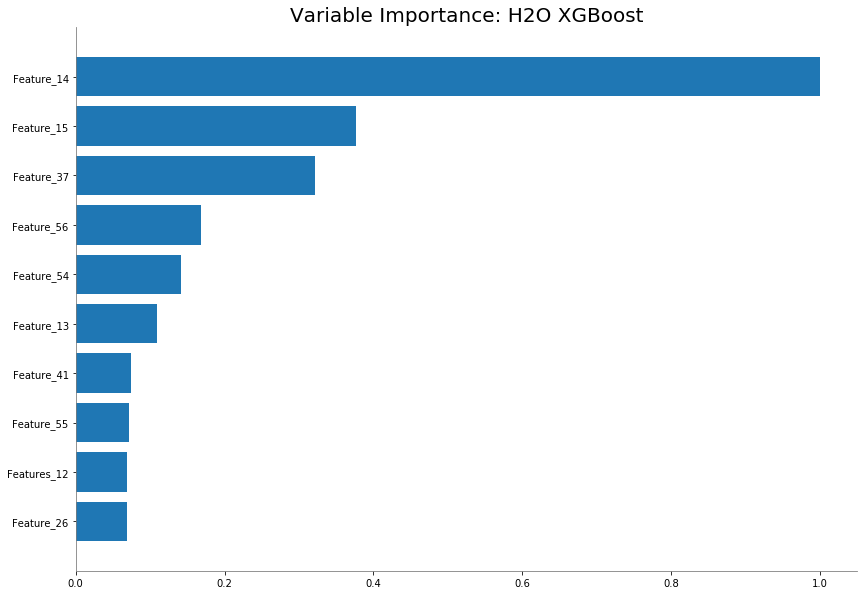

The Confusion Matrix is:  
 [[34764   217]
 [  133    86]]
The Accuracy on Test Set is:  0.9900568181818182
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     34981
           1       0.28      0.39      0.33       219

   micro avg       0.99      0.99      0.99     35200
   macro avg       0.64      0.69      0.66     35200
weighted avg       0.99      0.99      0.99     35200



TypeError: ignored

In [0]:
model_ids, se, metalearner = es_process('Report_Features.csv',no_of_models =10, debug = False)

In [0]:
''' code that do not work for now
numeric_transformer = Pipeline(steps = [('scaler',StandardScaler())])
preprocessor = ColumnTransformer(
transformers = [('num', numeric_transformer, numeric_list)])
data[numeric_list] = preprocessor.fit_transform(data[numeric_list])
'''

In [0]:
aml.leaderboard

Parse progress: |█████████████████████████████████████████████████████████| 100%
This H2OFrame is empty.


In [0]:
def predict_es_with_saved_model(filename):
  
    data_es = pd.read_csv(filename, index_col= 0, parse_dates=[0])
    standardized_saved_model = h2o.load_model('./leader_standardize_0424/XGBoost_1_AutoML_20190424_070314')
    
    #true label
    X = remove_data.iloc[:,:-1]
    y = remove_data['Target']
    import warnings
    warnings.filterwarnings("ignore")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, shuffle=False)
    
    #for Ren Hao's usage
    pd.DataFrame(X_train.index).to_csv('cleaned_train_index_es.csv')
    pd.DataFrame(X_test.index).to_csv('cleaned_test_index_es.csv')
    
    remove_data =  data_es[~data_es.isin([np.nan, np.inf, -np.inf]).any(1)]
    factor_list_es = ['feature_57', 'feature_58', 'Feature_45','Feature_47', 'Target']
    numeric_list_es = list(set(remove_data.columns) - set(factor_list_es))
    remove_data[numeric_list_es] = remove_data[numeric_list_es].apply(lambda x: (x-np.mean(x))/np.std(x), axis = 0)
    
    
    df = remove_data.copy(deep = True)
    h2o_df = df_to_h2oF(df, factor_list_es)
    
    train_h2o, test_h2o = h2o_df.split_frame(ratios = [2/3], seed = 610)
    
    preds_standardize = aml.leader.predict(df_to_h2oF(h2o.as_list(test_h2o).iloc[:, :-1], factor_list[:-1]))
    
    
    standardized_corn_predict_df.to_csv('standardized_corn_predict.csv')
    
    cm = confusion_matrix(test_h2o_pandas['Target'].values, (h2o.as_list(preds_standardize)['predict']>0.5))
    
    
    print(colored('The Confusion Matrix is: ', 'red'),'\n', cm)
    predict_accuracy_on_test_set = (cm[0,0] + cm[1,1])/(cm[0,0] + cm[1,1]+cm[1,0] + cm[0,1])
    print(colored('The Accuracy on Test Set is: ', 'blue'), colored(predict_accuracy_on_test_set, 'blue'))
    
    print(metrics.classification_report(y_true=test_h2o_pandas['Target'].values, y_pred=(h2o.as_list(preds_standardize)['predict']>0.5).astype(float)))

In [0]:
#y_pred = xgb_model.predict(X_test.as_matrix())

cm = confusion_matrix(test_h2o_pandas['Target'].values, (h2o.as_list(preds_standardize)['predict']>0.5))
print(colored('The Confusion Matrix is: ', 'red'),'\n', cm)
# Calculate the accuracy on test set
predict_accuracy_on_test_set = (cm[0,0] + cm[1,1])/(cm[0,0] + cm[1,1]+cm[1,0] + cm[0,1])
print(colored('The Accuracy on Test Set is: ', 'blue'), colored(predict_accuracy_on_test_set, 'blue'))

NameError: ignored

In [0]:
print(metrics.classification_report(y_true=test_h2o_pandas['Target'].values, y_pred=(h2o.as_list(preds_standardize)['predict']>0.5).astype(float)))


NameError: ignored

In [0]:
#y_pred = xgb_model.predict(X_test.as_matrix())

cm = confusion_matrix(test_h2o_pandas['Target'].values, (preds_pandas['predict']>0.5))
print(colored('The Confusion Matrix is: ', 'red'),'\n', cm)
# Calculate the accuracy on test set
predict_accuracy_on_test_set = (cm[0,0] + cm[1,1])/(cm[0,0] + cm[1,1]+cm[1,0] + cm[0,1])
print(colored('The Accuracy on Test Set is: ', 'blue'), colored(predict_accuracy_on_test_set, 'blue'))

The Confusion Matrix is:  
 [[34843    69]
 [   49   123]]
The Accuracy on Test Set is:  0.9966366434842093


In [0]:
print(metrics.classification_report(y_true=test_h2o_pandas['Target'].values, y_pred=(preds_pandas['predict'] > 0.5).astype(float)))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34912
           1       0.64      0.72      0.68       172

   micro avg       1.00      1.00      1.00     35084
   macro avg       0.82      0.86      0.84     35084
weighted avg       1.00      1.00      1.00     35084

